In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/dogs-vs-cats/test1.zip
/kaggle/input/dogs-vs-cats/train.zip
/kaggle/input/dogs-vs-cats/sampleSubmission.csv


# Separate cats and dogs images in /kaggle/working/cats and /kaggle/working/dogs 

In [2]:
import os
import zipfile
import shutil
import random
import glob

# Paths for train and test zip and working directory
input_dir = '/kaggle/input/dogs-vs-cats'
train_zip_path = os.path.join(input_dir, 'train.zip')
test_zip_path = os.path.join(input_dir, 'test1.zip')
working_dir = '/kaggle/working'

"""
    The idea is to first extract train file in some temp folder and
    then move cat and dog images in train and val folder in separate
    folder of cats and dogs
    
    temp_train/
    temp_test/
    
    train/
        - cat/
        - dog/
"""

# define paths for unziping
temp_train_dir = os.path.join(working_dir, 'temp_train')


# create directories for them
os.makedirs(temp_train_dir, exist_ok=True)

# define cat and dog dir for train and test
train_cat_dir = os.path.join(working_dir, 'train/cat')
train_dog_dir = os.path.join(working_dir, 'train/dog')


# Create directories
os.makedirs(train_cat_dir, exist_ok=True)
os.makedirs(train_dog_dir, exist_ok=True)

# Extract train.zip
with zipfile.ZipFile(train_zip_path, 'r') as zip_ref:
    zip_ref.extractall(temp_train_dir)

with zipfile.ZipFile(test_zip_path, 'r') as zip_ref:
    zip_ref.extractall()

    
# List cat and dog files for train
train_cat_files = glob.glob(os.path.join(temp_train_dir, 'train/cat.*.jpg'))
train_dog_files = glob.glob(os.path.join(temp_train_dir, 'train/dog.*.jpg'))

# Move files to train and val directories
for file in train_cat_files:
    base_file_name = os.path.basename(file)
    shutil.move(file, os.path.join(train_cat_dir, base_file_name))

for file in train_dog_files:
    base_file_name = os.path.basename(file)
    shutil.move(file, os.path.join(train_dog_dir, base_file_name))

print("Files have been split and moved successfully.")

# after moving remove temp_train_dir
shutil.rmtree(temp_train_dir)

print("Temp train directory has been removed")

Files have been split and moved successfully.
Temp train directory has been removed


 # Draw a random image

Random image path:  /kaggle/working/train/dog/dog.7803.jpg
Image Height and Width: 298, 500
Image class:  dog


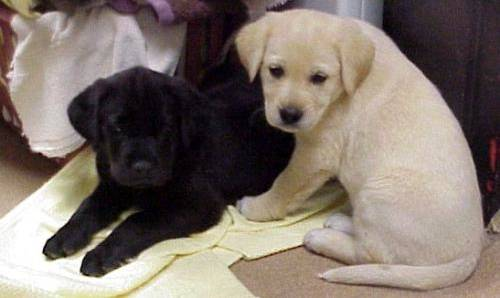

In [3]:
import random
from PIL import Image
from pathlib import Path

random.seed(42)

image_path = Path("/kaggle/working/train/")

image_path_list = list(image_path.glob("*/*.jpg"))

random_image_path = random.choice(image_path_list)

image_class = random_image_path.parent.stem

img = Image.open(random_image_path)
print("Random image path: ", random_image_path)
print(f"Image Height and Width: {img.height}, {img.width}")
print("Image class: ", image_class)
img

 Draw using numpy

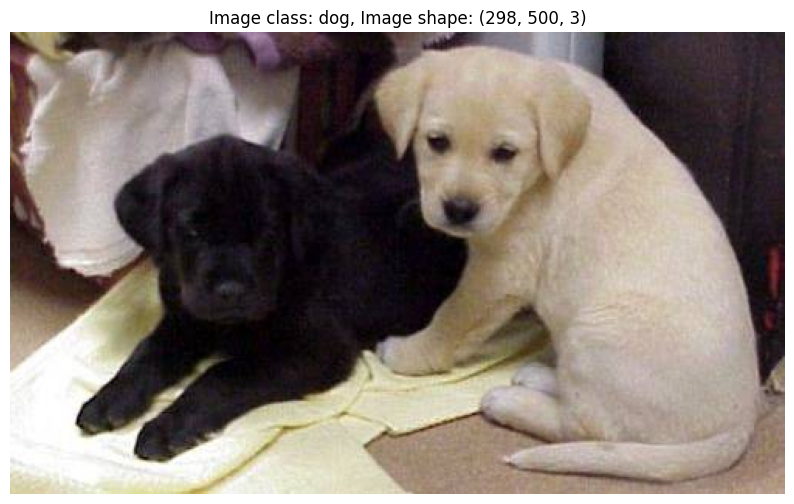

In [4]:
import numpy as np
import matplotlib.pyplot as plt

img_as_array = np.asarray(img)

plt.figure(figsize=(10, 7))
plt.imshow(img_as_array)

plt.title(f"Image class: {image_class}, Image shape: {img_as_array.shape}")
plt.axis(False);

 Transform the image(resize the image and then turn it into tensor)

In [5]:
import torch
import torchvision
from torchvision import transforms

IMG_SIZE = 224

train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])

# Peplicating ViT SOTA model from paper

In [6]:
import torch
from torchvision import transforms

INPUT_SIZE = 224

train_transform = transforms.Compose([
    transforms.Resize((INPUT_SIZE, INPUT_SIZE)),
    transforms.ToTensor()
])

In [7]:
# Set seeds
def set_seeds(seed: int=42):
    """Sets random sets for torch operations.

    Args:
        seed (int, optional): Random seed to set. Defaults to 42.
    """
    # Set the seed for general torch operations
    torch.manual_seed(seed)
    # Set the seed for CUDA torch operations (ones that happen on the GPU)
    torch.cuda.manual_seed(seed)

Take 500 images for training and 50 images for testing

In [8]:
from torch.utils.data import DataLoader, SubsetRandomSampler
from torchvision import datasets

BATCH_SIZE = 32
train_data_dir = Path('/kaggle/working/train')

train_dataset = datasets.ImageFolder(
    root = train_data_dir,
    transform = train_transform,
    target_transform = None

)

dataset_size = len(train_dataset)
indices = list(range(dataset_size))
np.random.shuffle(indices)

#if you wnat to split it into 20%
# split = int(np.floor(0.2*dataset_size))
#train_set, val_set = train_dataset[:split], train_dataset[split:]

NUM_SAMPLE_TRAIN = 500
NUM_SAMPLE_TEST = 50

train_indices = indices[: NUM_SAMPLE_TRAIN]
val_indices = indices[NUM_SAMPLE_TRAIN:NUM_SAMPLE_TRAIN + NUM_SAMPLE_TEST]

train_sample = SubsetRandomSampler(train_indices)
val_sample = SubsetRandomSampler(val_indices)

class_names = train_dataset.classes

train_dataloader = DataLoader(
    dataset = train_dataset,
    batch_size = BATCH_SIZE,
    sampler = train_sample, 
    num_workers = os.cpu_count()
)

val_dataloader = DataLoader(
    dataset = train_dataset,
    batch_size = BATCH_SIZE,
    sampler = val_sample,
    num_workers = os.cpu_count()
)


In [9]:
image_batch, label_batch = next(iter(train_dataloader))

image, label = image_batch[0], label_batch[0]

image.shape, label

(torch.Size([3, 224, 224]), tensor(1))

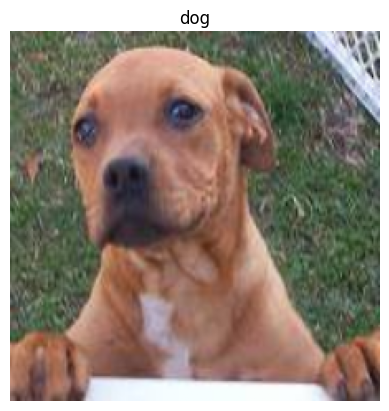

In [10]:
plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis(False);

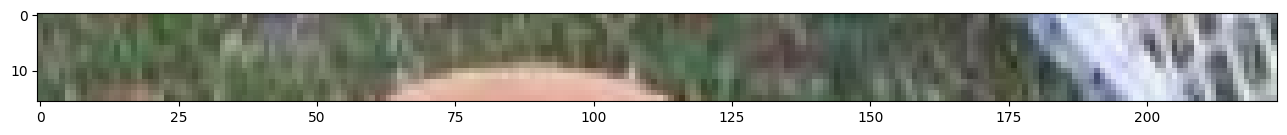

In [12]:
patch_size = 16
image_permuted = image.permute(1, 2, 0) # (H, W, C)
plt.figure(figsize=(patch_size, patch_size))
plt.imshow(image_permuted[:patch_size, :, :]);

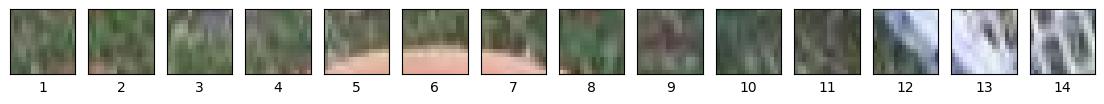

In [13]:
## patches for a single row
img_size = 224
patch_size = 16
num_patches = img_size / patch_size
fig, axs = plt.subplots(
    nrows = 1,
    ncols = img_size // patch_size,
    figsize = (num_patches, num_patches),
    sharex = True,
    sharey = True
)
for i, patch in enumerate(range(0, img_size, patch_size)):
    axs[i].imshow(image_permuted[:patch_size, patch: patch+patch_size, :]);
    axs[i].set_xlabel(i+1)
    axs[i].set_xticks([])
    axs[i].set_yticks([])


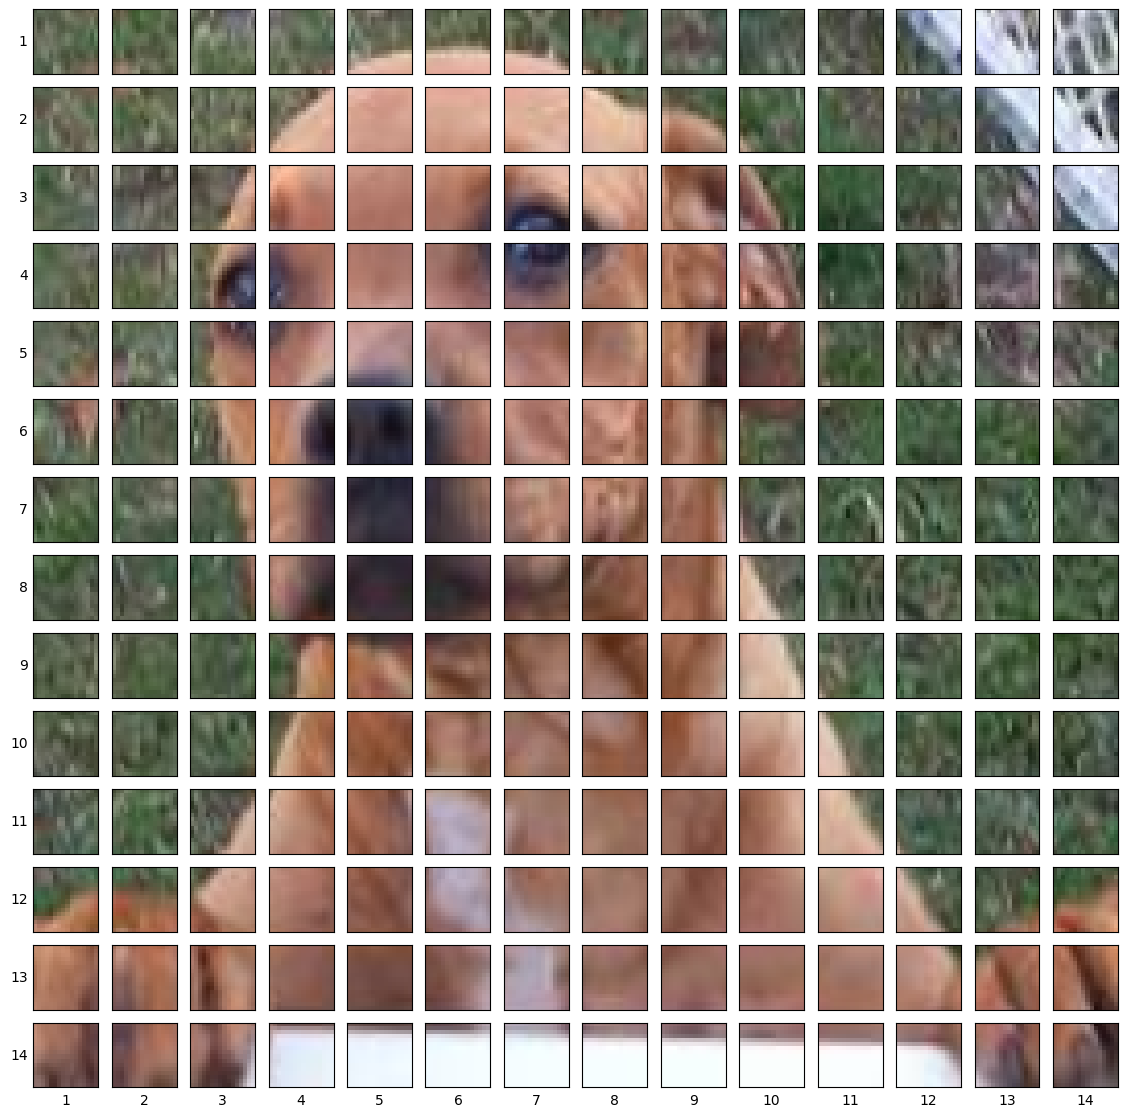

In [14]:
img_size = 224
patch_size = 16
num_patches = img_size / patch_size

fig, axs = plt.subplots(
    nrows=img_size // patch_size,
    ncols=img_size // patch_size,
    figsize=(num_patches, num_patches),
    sharex=True,
    sharey=True
)

for i, patch_height in enumerate(range(0, img_size, patch_size)):
    for j, patch_width in enumerate(range(0, img_size, patch_size)):
        axs[i, j].imshow(
            image_permuted[patch_height: patch_height + patch_size,
                          patch_width:patch_width+patch_size, :]
        )
        axs[i, j].set_ylabel(i+1,
                             rotation="horizontal",
                             horizontalalignment="right",
                             verticalalignment="center")
        axs[i, j].set_xlabel(j+1)
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])
        axs[i, j].label_outer()

Usng nn.Conv2d devide the image in patches by selecting kernel_size and stride

In [15]:
from torch import nn

patch_size = 16

conv2d = nn.Conv2d(
    in_channels=3,
    out_channels=768,
    kernel_size=patch_size,
    stride=patch_size,
    padding=0
)

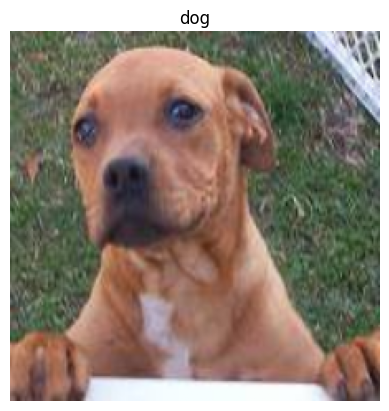

In [16]:
# View single image
plt.imshow(image.permute(1, 2, 0)) # adjust for matplotlib
plt.title(class_names[label])
plt.axis(False);

In [19]:
#pass the image through conv2d
image_conv = conv2d(image.unsqueeze(0))
image_conv.shape

torch.Size([1, 768, 14, 14])

Showing random convolutional feature maps from indexes: [142, 754, 104, 692, 558]


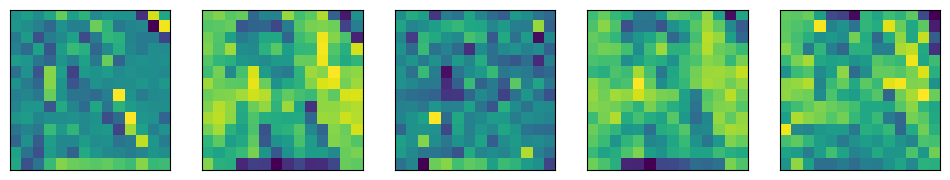

In [20]:
# Plot random 5 convolutional feature maps
import random
random_indexes = random.sample(range(0, 758), k=5) # pick 5 numbers between 0 and the embedding size
print(f"Showing random convolutional feature maps from indexes: {random_indexes}")

# Create plot
fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(12, 12))

# Plot random image feature maps
for i, idx in enumerate(random_indexes):
    image_conv_feature_map = image_conv[:, idx, :, :] # index on the output tensor of the convolutional layer
    axs[i].imshow(image_conv_feature_map.squeeze().detach().numpy())
    axs[i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[]);

In [21]:
# Create flatten layer
flatten = nn.Flatten(start_dim=2, # flatten feature_map_height (dimension 2)
                     end_dim=3) #

In [22]:

image_out_of_conv_flattened = flatten(image_conv)
image_out_of_conv_flattened.shape

torch.Size([1, 768, 196])

In [23]:
# Get flattened image patch embeddings in right shape
image_out_of_conv_flattened_reshaped = image_out_of_conv_flattened.permute(0, 2, 1) # [batch_size, P^2•C, N] -> [batch_size, N, P^2•C]
print(f"Patch embedding sequence shape: {image_out_of_conv_flattened_reshaped.shape} -> [batch_size, num_patches, embedding_size]")

Patch embedding sequence shape: torch.Size([1, 196, 768]) -> [batch_size, num_patches, embedding_size]


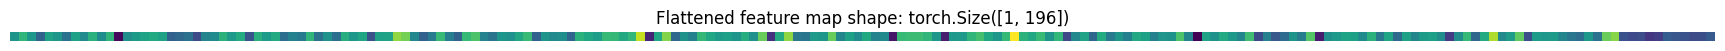

In [24]:
# Get a single flattened feature map
single_flattened_feature_map = image_out_of_conv_flattened_reshaped[:, :, 0] # index: (batch_size, number_of_patches, embedding_dimension)

# Plot the flattened feature map visually
plt.figure(figsize=(22, 22))
plt.imshow(single_flattened_feature_map.detach().numpy())
plt.title(f"Flattened feature map shape: {single_flattened_feature_map.shape}")
plt.axis(False);

# Create a patch embedding class

In [26]:
###Create a patch embeding class
class PatchEmbeding(nn.Module):
    def __init__(self,
        in_channels:int = 3,
        patch_size:int = 16,
        embedding_dim:int = 768
        
    ):
        super().__init__()
        self.patcher = nn.Conv2d(in_channels = in_channels,
                                out_channels = embedding_dim,
                                kernel_size = patch_size,
                                stride = patch_size,
                                padding = 0)
        self.flatten = nn.Flatten(start_dim=2, end_dim=3)
    
    def forward(self, x):
        
        image_resolution = x.shape[-1]
        assert image_resolution % patch_size == 0, f"Input image size must be divisble by patch size, image shape: {image_resolution}, patch size: {patch_size}"
        ##perform the forward pass
        x_patched = self.patcher(x)
        x_flatten = self.flatten(x_patched)
        return x_flatten.permute(0,2,1)

In [27]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)


patchify = PatchEmbeding(in_channels=3,
                         patch_size=16,
                         embedding_dim=768)

# Pass a single image through
print(f"Input image shape: {image.unsqueeze(0).shape}")
patch_embedded_image = patchify(image.unsqueeze(0)) # add an extra batch dimension on the 0th index, otherwise will error
print(f"Output patch embedding shape: {patch_embedded_image.shape}")

Input image shape: torch.Size([1, 3, 224, 224])
Output patch embedding shape: torch.Size([1, 196, 768])


In [28]:
# Get the batch size and embedding dimension
batch_size = patch_embedded_image.shape[0]
embedding_dimension = patch_embedded_image.shape[-1]

# Create the class token embedding as a learnable parameter that shares the same size as the embedding dimension (D)
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension), # [batch_size, number_of_tokens, embedding_dimension]
                           requires_grad=True) # make sure the embedding is learnable

# Show the first 10 examples of the class_token
print(class_token[:, :, :10])

# Print the class_token shape
print(f"Class token shape: {class_token.shape} -> [batch_size, number_of_tokens, embedding_dimension]")

tensor([[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]], grad_fn=<SliceBackward0>)
Class token shape: torch.Size([1, 1, 768]) -> [batch_size, number_of_tokens, embedding_dimension]


In [29]:
# Add the class token embedding to the front of the patch embedding
patch_embedded_image_with_class_embedding = torch.cat((class_token, patch_embedded_image),
                                                      dim=1) # concat on first dimension

# Print the sequence of patch embeddings with the prepended class token embedding
print(patch_embedded_image_with_class_embedding)
print(f"Sequence of patch embeddings with class token prepended shape: {patch_embedded_image_with_class_embedding.shape} -> [batch_size, number_of_patches, embedding_dimension]")

tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
         [-0.4789,  0.1060, -0.1443,  ...,  0.2995, -0.1626,  0.2254],
         [-0.4519,  0.1146, -0.2051,  ...,  0.3234, -0.1779,  0.1509],
         ...,
         [-0.6427,  0.2076, -0.5429,  ...,  0.5988, -0.1004,  0.4543],
         [-0.3792,  0.0518, -0.1602,  ...,  0.2891, -0.1770,  0.2614],
         [-0.3566,  0.0281, -0.1773,  ...,  0.2577, -0.1420,  0.1762]]],
       grad_fn=<CatBackward0>)
Sequence of patch embeddings with class token prepended shape: torch.Size([1, 197, 768]) -> [batch_size, number_of_patches, embedding_dimension]


In [30]:
height = 224
width = 224
patch_size = 16
#calculate number of patches 
number_of_patches = int((height*width) / patch_size**2)

# Get the embedding dimension
embedding_dimension = patch_embedded_image_with_class_embedding.shape[2]

#Create nthe learnable 1D position embedding
position_embedding = nn.Parameter(torch.ones(1,
                                            number_of_patches+1,
                                            embedding_dimension),
                                 requires_grad = True) # make sure it's learnable
# Show the first 10 sequences and 10 position embedding values and check the shape of the position embedding
print(position_embedding[:, :10, :10])
print(f"Position embedding shape : {position_embedding.shape} -> [batch_size, number_of_patches, embedding_dimension]")

tensor([[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]], grad_fn=<SliceBackward0>)
Position embedding shape : torch.Size([1, 197, 768]) -> [batch_size, number_of_patches, embedding_dimension]


In [31]:
# Add the position embedding to the patch and class token embedding
patch_and_position_embedding = patch_embedded_image_with_class_embedding + position_embedding
print(patch_and_position_embedding)
print(f"Patch embeddings, class token prepended and positional embeddings added shape: {patch_and_position_embedding.shape} -> [batch_size, number_of_patches, embedding_dimension]")

tensor([[[2.0000, 2.0000, 2.0000,  ..., 2.0000, 2.0000, 2.0000],
         [0.5211, 1.1060, 0.8557,  ..., 1.2995, 0.8374, 1.2254],
         [0.5481, 1.1146, 0.7949,  ..., 1.3234, 0.8221, 1.1509],
         ...,
         [0.3573, 1.2076, 0.4571,  ..., 1.5988, 0.8996, 1.4543],
         [0.6208, 1.0518, 0.8398,  ..., 1.2891, 0.8230, 1.2614],
         [0.6434, 1.0281, 0.8227,  ..., 1.2577, 0.8580, 1.1762]]],
       grad_fn=<AddBackward0>)
Patch embeddings, class token prepended and positional embeddings added shape: torch.Size([1, 197, 768]) -> [batch_size, number_of_patches, embedding_dimension]


# Image to embedding with position

In [ ]:
###Image to embedding with position
torch.manual_seed(42)
torch.cuda.manual_seed(42)

patch_size = 16

print(f"print the original size of the image {image.shape}")

# add extra dimension using unsqueez
x = image.unsqueeze(0)

print(f"Input image with batch dimension shape : {x.shape}")

# create patch embedding layer
patch_embedding_layer = PatchEmbeding(
    in_channels = 3,
    patch_size = patch_size,
    embedding_dim = 768
)

#pass image through image embedding layer
patch_embedding = patch_embedding_layer(x)
print(f"Patch embedding shape: {patch_embedding.shape}")

#create class token embedding
batch_size = patch_embedding.shape[0]
embedding_dimension = patch_embedding.shape[2]
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension), requires_grad = True)
print(f"Class token dimension : {class_token.shape}")

#prepend class token embedding to patch embedding
patch_embedding_class_token = torch.cat((class_token, patch_embedding), dim = 1)
# patch embedding with class token
print(f"patch embedding with token shape : {patch_embedding_class_token.shape}")

# 8. Create position embedding
number_of_patches = int((height * width) / patch_size**2)
position_embedding = nn.Parameter(torch.ones(1, number_of_patches+1, embedding_dimension),
                                  requires_grad=True)

# 9. Add position embedding to patch embedding with class token
patch_and_position_embedding = patch_embedding_class_token + position_embedding
print(f"Patch and position embedding shape: {patch_and_position_embedding.shape}")


# Multihead attention class

In [32]:
###Multihead attention
class MultiheadSelfAttentionBlock(nn.Module):
    def __init__(self,
                embedding_dim : int=768,
                num_heads : int = 12,
                 attn_dropout : float = 0
                ):
        super().__init__()
        #create the norm layer
        self.layer_norm = nn.LayerNorm(normalized_shape = embedding_dim)
        
        #create the multihead attention layer
        self.multihead_attn = nn.MultiheadAttention(embed_dim=embedding_dim, num_heads=num_heads, batch_first=True)
        
    def forward(self,x):
        x = self.layer_norm(x)
        attn_output, _ = self.multihead_attn(query=x,
                                     key=x,
                                     value=x,
                                     need_weights=False)
        return attn_output

In [33]:
# Create an instance of MSABlock
multihead_self_attention_block = MultiheadSelfAttentionBlock(embedding_dim=768, # from Table 1
                                                             num_heads=12) # from Table 1

# Pass patch and position image embedding through MSABlock
patched_image_through_msa_block = multihead_self_attention_block(patch_and_position_embedding)
print(f"Input shape of MSA block: {patch_and_position_embedding.shape}")
print(f"Output shape MSA block: {patched_image_through_msa_block.shape}")

Input shape of MSA block: torch.Size([1, 197, 768])
Output shape MSA block: torch.Size([1, 197, 768])


# MLPBlock

In [34]:
#Create a class that inherts from  nn.Module from the paper
class MLPBlock(nn.Module):
    #initialize the class with hyperparameters
    def __init__(self,
                embedding_dim : int = 768,
                mlp_size : int = 3072,
                dropout : float = 0.1):
        super().__init__()
        #Create the norm layer
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)

        #create the multilayer perceptron layer
        self.mlp = nn.Sequential(
            nn.Linear(in_features=embedding_dim,
                     out_features=mlp_size),
            nn.GELU(),
            nn.Dropout(p=dropout),
            nn.Linear(in_features=mlp_size,
                     out_features=embedding_dim),
            nn.Dropout(p=dropout)

        )

    #Create a forward method to pass the data through the layers
    def forward(self, x):
        x = self.layer_norm(x)
        x = self.mlp(x)
        return x


In [35]:
# Create an instance of MLPBlock
mlp_block = MLPBlock(embedding_dim=768, # from Table 1
                     mlp_size=3072, # from Table 1
                     dropout=0.1) # from Table 3

# Pass output of MSABlock through MLPBlock
patched_image_through_mlp_block = mlp_block(patched_image_through_msa_block)
print(f"Input shape of MLP block: {patched_image_through_msa_block.shape}")
print(f"Output shape MLP block: {patched_image_through_mlp_block.shape}")

Input shape of MLP block: torch.Size([1, 197, 768])
Output shape MLP block: torch.Size([1, 197, 768])


# Create transformerEncoderBlock class as define in ViT paper

In [36]:
# 1. Create a class that inherits from nn.Module
class TransformerEncoderBlock(nn.Module):
    """Creates a Transformer Encoder block."""
    # 2. Initialize the class with hyperparameters from Table 1 and Table 3
    def __init__(self,
                 embedding_dim:int=768, # Hidden size D from Table 1 for ViT-Base
                 num_heads:int=12, # Heads from Table 1 for ViT-Base
                 mlp_size:int=3072, # MLP size from Table 1 for ViT-Base
                 mlp_dropout:float=0.1, # Amount of dropout for dense layers from Table 3 for ViT-Base
                 attn_dropout:float=0): # Amount of dropout for attention layers
        super().__init__()

        # 3. Create MSA block (equation 2)
        self.msa_block = MultiheadSelfAttentionBlock(embedding_dim=embedding_dim,
                                                     num_heads=num_heads,
                                                     attn_dropout=attn_dropout)

        # 4. Create MLP block (equation 3)
        self.mlp_block =  MLPBlock(embedding_dim=embedding_dim,
                                   mlp_size=mlp_size,
                                   dropout=mlp_dropout)

    # 5. Create a forward() method
    def forward(self, x):

        # 6. Create residual connection for MSA block (add the input to the output)
        x =  self.msa_block(x) + x

        # 7. Create residual connection for MLP block (add the input to the output)
        x = self.mlp_block(x) + x

        return x

In [37]:
# Create an instance of TransformerEncoderBlock
transformer_encoder_block = TransformerEncoderBlock()

# Now full Vit Transformer

In [38]:
### ViT architecture

#Create the class that inhierit from nn.Module
class ViT(nn.Module):
    
    def __init__(self,
                 img_size:int=224, # Training resolution from Table 3 in ViT paper
                 in_channels:int=3, # Number of channels in input image
                 patch_size:int=16, # Patch size
                 num_transformer_layers:int=12, # Layers from Table 1 for ViT-Base
                 embedding_dim:int=768, # Hidden size D from Table 1 for ViT-Base
                 mlp_size:int=3072, # MLP size from Table 1 for ViT-Base
                 num_heads:int=12, # Heads from Table 1 for ViT-Base
                 attn_dropout:float=0, # Dropout for attention projection
                 mlp_dropout:float=0.1, # Dropout for dense/MLP layers
                 embedding_dropout:float=0.1, # Dropout for patch and position embeddings
                 num_classes:int=1000):
        super().__init__()
        assert img_size % patch_size == 0, f"Image size must be divisible by patch_size"
        
        #Calculate the number of patch sizze
        self.num_patches = (img_size*img_size)//patch_size**2
        
        #create learnable class embedding
        self.class_embedding = nn.Parameter(data=torch.rand(1,1,embedding_dim), requires_grad=True)
        
        #Create learnable positional embedding
        self.position_embedding = nn.Parameter(data = torch.rand(1, self.num_patches+1,embedding_dim), requires_grad=True)
        
        #Create embedding dropout
        self.embedding_dropout = nn.Dropout(p=embedding_dropout)
        
        #create patch embedding layer
        self.patch_embedding = PatchEmbeding(in_channels,patch_size,embedding_dim)
        
        #Create transformer Encoder block
        self.transformer_encoder = nn.Sequential(*[TransformerEncoderBlock(embedding_dim=embedding_dim,
                                                                            num_heads=num_heads,
                                                                            mlp_size=mlp_size,
                                                                            mlp_dropout=mlp_dropout) for _ in range(num_transformer_layers)])
        self.classifier = nn.Sequential(
            nn.LayerNorm(normalized_shape=embedding_dim),
            nn.Linear(in_features=embedding_dim,
                      out_features=num_classes)
        )

    #  Create a forward() method
    def forward(self, x):

        # Get batch size
        batch_size = x.shape[0]

        # Create class token embedding and expand it to match the batch size (equation 1)
        class_token = self.class_embedding.expand(batch_size, -1, -1) # "-1" means to infer the dimension (try this line on its own)

        # Create patch embedding (equation 1)
        x = self.patch_embedding(x)

        # Concat class embedding and patch embedding (equation 1)
        x = torch.cat((class_token, x), dim=1)

        #  Add position embedding to patch embedding (equation 1)
        x = self.position_embedding + x

        # Run embedding dropout (Appendix B.1)
        x = self.embedding_dropout(x)

        # Pass patch, position and class embedding through transformer encoder layers (equations 2 & 3)
        x = self.transformer_encoder(x)

        # Put 0 index logit through classifier (equation 4)
        x = self.classifier(x[:, 0]) # run on each sample in a batch at 0 index

        return x
        
        

In [39]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Create a random tensor with same shape as a single image
random_image_tensor = torch.randn(1, 3, 224, 224) # (batch_size, color_channels, height, width)

# Create an instance of ViT with the number of classes we're working with (cat and dog)
vit = ViT(num_classes=len(class_names))

# Pass the random image tensor to our ViT instance
vit(random_image_tensor)

tensor([[-0.0709, -0.6442]], grad_fn=<AddmmBackward0>)

In [40]:
from torchinfo import summary

# Print a summary of our custom ViT model using torchinfo (uncomment for actual output)
summary(model=vit,
        input_size=(32, 3, 224, 224), # (batch_size, color_channels, height, width)
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
ViT (ViT)                                                    [32, 3, 224, 224]    [32, 2]              152,064              True
├─PatchEmbeding (patch_embedding)                            [32, 3, 224, 224]    [32, 196, 768]       --                   True
│    └─Conv2d (patcher)                                      [32, 3, 224, 224]    [32, 768, 14, 14]    590,592              True
│    └─Flatten (flatten)                                     [32, 768, 14, 14]    [32, 768, 196]       --                   --
├─Dropout (embedding_dropout)                                [32, 197, 768]       [32, 197, 768]       --                   --
├─Sequential (transformer_encoder)                           [32, 197, 768]       [32, 197, 768]       --                   True
│    └─TransformerEncoderBlock (0)                           [32, 197, 768]       [32, 197, 768]

In [41]:
### Optimizer and loss function
optimizer = torch.optim.Adam(params = vit.parameters(), lr = 3e-3, betas=(0.9, 0.999), # default values but also mentioned in ViT paper section 4.1 (Training & Fine-tuning)
                             weight_decay=0.3)
loss_fn = nn.CrossEntropyLoss()

# Create a train and test loop function

In [42]:
###Create  train and test loop function
def train_step(model : torch.nn.Module,
              dataloader : torch.utils.data.DataLoader,
              loss_fn : torch.nn.Module,
              optimizer : torch.optim.Optimizer,
              device : str='gpu'):
    #put the model in train mode
    model.train()
    
    #setup train loss and accuracy values
    train_loss, train_acc = 0, 0
    
    #loop through data loader data batches
    for batch, (X,y) in enumerate(dataloader):
        X,y = X.to(device), y.to(device)
        
        #forward pass
        y_pred = model(X)
        
        #Calculate loss and accumulate loss
        loss = loss_fn(y_pred,y)
        train_loss += loss.item()
        
        #optimizer zero grad
        optimizer.zero_grad()
        
        #loss backward
        loss.backward()
        
        #optimizer step step
        optimizer.step()
        
        #calculate and accumulate the accuracy matrics accross all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item() / len(y_pred)
    # adjust matrics to get average loss and accuracy per 
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

In [43]:
len(train_dataloader), len(val_dataloader)

(16, 2)

In [44]:
def test_step(model : torch.nn.Module,
             dataloader : torch.utils.data.DataLoader,
             loss_fn : torch.nn.Module,
             device : str):
    model.eval()
    test_loss, test_acc = 0, 0
    with torch.inference_mode():
        for batch, (X,y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)
            test_pred_logits = model(X)
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()
            
            test_pred_labels = torch.argmax(torch.softmax(test_pred_logits, dim=1), dim=1)
            test_acc += ((test_pred_labels == y).sum().item() / len(test_pred_labels))
        test_loss = test_loss / len(dataloader)
        test_acc = test_acc / len(dataloader)
        return test_loss, test_acc

In [45]:
!pip install tqdm

# Combining train and test step

In [46]:
### Combining train and test step
from tqdm import tqdm

def train(
    model:torch.nn.Module,
    train_dataloader: torch.utils.data.DataLoader,
    test_dataloader: torch.utils.data.DataLoader,
    optimizer: torch.optim.Optimizer,
    loss_fn: torch.nn.Module=torch.nn.CrossEntropyLoss(),
    epochs: int=100,
    device:str="cpu"
):
    results = {
        "train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(
            model=model,
            dataloader=train_dataloader,
            loss_fn=loss_fn,
            optimizer=optimizer,
            device=device
        )
        
        test_loss, test_acc = test_step(
            model=model,
            dataloader=test_dataloader,
            loss_fn=loss_fn,
            device=device
        )
        
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )
        
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)
        
    return results

In [47]:
from torchvision import datasets
from torch.utils.data import DataLoader, SubsetRandomSampler

BATCH_SIZE = 32
train_dataset_dir = Path("/kaggle/working/train/")

train_dataset = datasets.ImageFolder(
    root=train_dataset_dir,
    transform=train_transform,
    target_transform=None
)

dataset_size = len(train_dataset)
indices = list(range(dataset_size))
np.random.shuffle(indices)

# If you want to divide it by 20%
# split = int(np.floor(0.2 * dataset_size))
# train_indices, val_indices = indices[split:], indices[:split]

NUM_TRAIN_SAMPLES = 500
NUM_VAL_SAMPLES = 50

# Select 500 indices for training and 50 for validation
train_indices = indices[:NUM_TRAIN_SAMPLES]
val_indices = indices[NUM_TRAIN_SAMPLES:NUM_TRAIN_SAMPLES + NUM_VAL_SAMPLES]

train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

class_names = train_dataset.classes
train_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    sampler=train_sampler,
    num_workers=os.cpu_count()
)

val_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    sampler=val_sampler,
    num_workers=os.cpu_count()
)

In [ ]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

device = "cuda" if torch.cuda.is_available() else "cpu"

# Train the model and save the training results to a dictionary
model_0_results = train(model=vit.to(device),
                       train_dataloader=train_dataloader,
                       test_dataloader=val_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=10,
                       device=device)

 10%|█         | 1/10 [09:28<1:25:18, 568.69s/it]

Epoch: 1 | train_loss: 1.9026 | train_acc: 0.4977 | test_loss: 0.9895 | test_acc: 0.5868


 20%|██        | 2/10 [18:40<1:14:29, 558.71s/it]

Epoch: 2 | train_loss: 0.7786 | train_acc: 0.5152 | test_loss: 0.7281 | test_acc: 0.4010


 30%|███       | 3/10 [27:37<1:04:01, 548.80s/it]

Epoch: 3 | train_loss: 0.6953 | train_acc: 0.5406 | test_loss: 0.7205 | test_acc: 0.3767


 40%|████      | 4/10 [36:31<54:18, 543.06s/it]  

Epoch: 4 | train_loss: 0.7051 | train_acc: 0.4570 | test_loss: 0.6923 | test_acc: 0.5747


 50%|█████     | 5/10 [45:23<44:54, 538.98s/it]

Epoch: 5 | train_loss: 0.7305 | train_acc: 0.4820 | test_loss: 0.7228 | test_acc: 0.4253


 60%|██████    | 6/10 [54:09<35:38, 534.57s/it]

Epoch: 6 | train_loss: 0.7189 | train_acc: 0.5199 | test_loss: 0.7065 | test_acc: 0.4010


 70%|███████   | 7/10 [1:02:54<26:34, 531.35s/it]

Epoch: 7 | train_loss: 0.7248 | train_acc: 0.4988 | test_loss: 0.6892 | test_acc: 0.5868


 80%|████████  | 8/10 [1:11:34<17:35, 527.91s/it]

Epoch: 8 | train_loss: 0.7148 | train_acc: 0.5098 | test_loss: 0.6954 | test_acc: 0.4132


 90%|█████████ | 9/10 [1:20:24<08:48, 528.62s/it]

Epoch: 9 | train_loss: 0.7098 | train_acc: 0.4918 | test_loss: 0.7159 | test_acc: 0.4375


In [ ]:
len(train_dataloader)

In [ ]:
from torch import nn

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

# Apply trainsfer learning in ViT model

In [ ]:
### we get train acc 50% with 500 training images. Let's apply trainsfer learning in ViT
import torchvision.models as models
pretrained_vit_weights = models.ViT_B_16_Weights.DEFAULT

pretrained_vit = models.vit_b_16(weights=pretrained_vit_weights)

#frize the base parameter
for parameter in pretrained_vit.parameters():
    parameter.requires_grad = False
set_seeds()
pretrained_vit.heads = nn.Linear(in_features=768, out_features=len(class_names)).to(device)

In [ ]:
from torchinfo import summary
# Print a summary using torchinfo (uncomment for actual output)
summary(model=pretrained_vit,
        input_size=(32, 3, 224, 224), # (batch_size, color_channels, height, width)
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

In [ ]:
# Get automatic transforms from pretrained ViT weights
pretrained_vit_transforms = pretrained_vit_weights.transforms()
print(pretrained_vit_transforms)

In [ ]:
set_seeds()

# its important to provide pretrained_vit.parameters here
optimizer = torch.optim.Adam(params=pretrained_vit.parameters(),
                             lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss()

model_1_results = train(model=pretrained_vit.to(device),
                       train_dataloader=train_dataloader,
                       test_dataloader=val_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=10,
                       device=device)

 ### How to improve accuracy?
 1. We can increase number of images of train data 
 2. We can train longer by increasing the number of epochs

In [ ]:
###Increase the data to 20%
from torchvision import datasets
from torch.utils.data import DataLoader, SubsetRandomSampler

BATCH_SIZE = 32
train_dataset_dir = Path("/kaggle/working/train/")

train_dataset = datasets.ImageFolder(
    root=train_dataset_dir,
    transform=pretrained_vit_transforms,
    target_transform=None
)

dataset_size = len(train_dataset)
indices = list(range(dataset_size))
np.random.shuffle(indices)

# If you want to divide it by 20%
# split = int(np.floor(0.2 * dataset_size))
# train_indices, val_indices = indices[split:], indices[:split]

NUM_TRAIN_SAMPLES = int(np.floor(0.2*dataset_size))

NUM_VAL_SAMPLES = 50

# Select 500 indices for training and 50 for validation
train_indices = indices[:NUM_TRAIN_SAMPLES]
val_indices = indices[NUM_TRAIN_SAMPLES:NUM_TRAIN_SAMPLES + NUM_VAL_SAMPLES]

train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

class_names = train_dataset.classes
train_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    sampler=train_sampler,
    num_workers=os.cpu_count()
)

val_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    sampler=val_sampler,
    num_workers=os.cpu_count()
)

In [ ]:
len(train_indices), len(val_indices)


In [ ]:
set_seeds()
optimizer = torch.optim.Adam(params=pretrained_vit.parameters(),
                             lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss()
model_2_results = train(model=pretrained_vit.to(device),
                       train_dataloader=train_dataloader,
                       test_dataloader=val_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=10,
                       device=device)

In [ ]:
from typing import Tuple, Dict, List
def plot_loss_curves(results: Dict[str, List[float]]):
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "test_loss": [...],
             "test_acc": [...]}
    """
    
    # Get the loss values of the results dictionary (training and test)
    loss = results['train_loss']
    test_loss = results['test_loss']

    # Get the accuracy values of the results dictionary (training and test)
    accuracy = results['train_acc']
    test_accuracy = results['test_acc']

    # Figure out how many epochs there were
    epochs = range(len(results['train_loss']))

    # Setup a plot 
    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, test_loss, label='test_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='train_accuracy')
    plt.plot(epochs, test_accuracy, label='test_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();

In [ ]:
plot_loss_curves(model_2_results)

**TesTing**

# Custom DataLoader for test images

In [ ]:
from torch.utils.data import Dataset
class CustomTestDataset(Dataset):
    def __init__(self, img_dir, transform=None):
        self.img_dir = img_dir
        self.transform = transform
        self.img_paths = list(Path(img_dir).rglob("*.*"))  # List all files in the directory

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        image = Image.open(img_path).convert("RGB")  # Convert to RGB
        if self.transform:
            image = self.transform(image)
        return image, img_path.name 

In [ ]:
class PrepareOutputData:
    def __init__(self, test_dir, model, batch_size, custom_transform):
        self.model = model
        self.transform = custom_transform
        self.test_data = CustomTestDataset(test_dir, transform=self.transform)
        self.test_data_loader = torch.utils.data.DataLoader(self.test_data, batch_size=batch_size, shuffle=False)
        self.submission = [['label']]
        
    def evaluatePredictionLabels(self):
        with torch.inference_mode():
            self.model.eval()
            for images, _ in self.test_data_loader:
                images = images.to(device)
                pred_logits = self.model(images)
                prediction_batch = torch.argmax(torch.softmax(pred_logits, dim=1), dim=1)
                for prediction in prediction_batch:
                    self.submission.append([prediction.item()])
                    
    
    def savePredictedOutput(self):
        with open('submission.csv', 'w') as submissionFile:
            writer = csv.writer(submissionFile)
            writer.writerows(self.submission)

        print('Output saved to submission.csv')

In [ ]:
test_dir = Path(os.path.join(working_dir, "test1/"))
output_instance = PrepareOutputData(
    test_dir=test_dir, 
    model=pretrained_vit.to(device), 
    batch_size=BATCH_SIZE,
    custom_transform=pretrained_vit_transforms
)

# evaluate images
output_instance.evaluatePredictionLabels()

In [ ]:
output_instance.savePredictedOutput()

In [ ]:
from typing import List, Tuple

from PIL import Image

# 1. Take in a trained model, class names, image path, image size, a transform and target device
def pred_and_plot_image(model: torch.nn.Module,
                        image_path: str, 
                        class_names: List[str],
                        image_size: Tuple[int, int] = (224, 224),
                        transform: torchvision.transforms = None,
                        device: torch.device=device):
    
    
    # 2. Open image
    img = Image.open(image_path)

    # 3. Create transformation for image (if one doesn't exist)
    if transform is not None:
        image_transform = transform
    else:
        image_transform = transforms.Compose([
            transforms.Resize(image_size),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225]),
        ])

    ### Predict on image ### 

    # 4. Make sure the model is on the target device
    model.to(device)

    # 5. Turn on model evaluation mode and inference mode
    model.eval()
    with torch.inference_mode():
      # 6. Transform and add an extra dimension to image (model requires samples in [batch_size, color_channels, height, width])
      transformed_image = image_transform(img).unsqueeze(dim=0)

      # 7. Make a prediction on image with an extra dimension and send it to the target device
      target_image_pred = model(transformed_image.to(device))

    # 8. Convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

    # 9. Convert prediction probabilities -> prediction labels
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

    # 10. Plot image with predicted label and probability 
    plt.figure()
    plt.imshow(img)
    plt.title(f"Pred: {class_names[target_image_pred_label]} | Prob: {target_image_pred_probs.max()*100:.2f}%")
    plt.axis(False);

In [ ]:
img_paths = list(Path(test_dir).rglob("*.*"))
random_image_path = random.choice(img_paths)
pred_and_plot_image(model=pretrained_vit,
                   image_path=random_image_path,
                   class_names=class_names)